In [2]:
import itertools
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import linalg
from scipy.spatial.distance import cdist
from sklearn import tree, mixture
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, log_loss, plot_confusion_matrix, silhouette_score, calinski_harabasz_score, \
    davies_bouldin_score, silhouette_samples, homogeneity_score, completeness_score, v_measure_score, \
    adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
import nltk
import re
import time
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.random_projection import GaussianRandomProjection
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer


data = pd.read_csv("bbc-text.csv")
print(data['category'].value_counts())
data['text_clean'] = data['text'].apply(nltk.word_tokenize)
print('done tokenize')
stop_words=set(nltk.corpus.stopwords.words("english"))
data['text_clean'] = data['text_clean'].apply(lambda x: [item for item in x if item not in stop_words])
regex = '[a-z]+'
print('done stop words')
data['text_clean'] = data['text_clean'].apply(lambda x: [item for item in x if re.match(regex, item)])
lem = nltk.stem.wordnet.WordNetLemmatizer()
data['text_clean'] = data['text_clean'].apply(lambda x: [lem.lemmatize(item, pos='v') for item in x])
print("done lemmatizer")


# data = shuffle(data)
# std_scaler = StandardScaler()
# copy_both_df = data.copy()
X = data.loc[:, data.columns != "category"]

# std_scaler.fit(X)
# X_scaled = std_scaler.fit_transform(X)
enc = LabelEncoder()
y = enc.fit_transform(data['category'])
labels = list(enc.classes_)

# dtc = tree.DecisionTreeClassifier(criterion="entropy", max_depth=20, min_samples_split=15, random_state = 3)
# X_train, X_test, y_train, y_test = train_test_split(data['text'], y, random_state=2, test_size=.2, stratify=y)
vec = TfidfVectorizer()
# X_train_vec = vec.fit_transform(X_train)
# X_test_vec = vec.transform(X_test)

X_scaled_prevec = data['text']
X_scaled = vec.fit_transform(X_scaled_prevec)
y_encode = y
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encode, random_state=2, test_size=.4, stratify=y_encode)
print("done preparing data")

C:\Users\Stephen\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Stephen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Stephen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Stephen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64
done tokenize
done stop words
done lemmatizer
done preparing data


done processing models


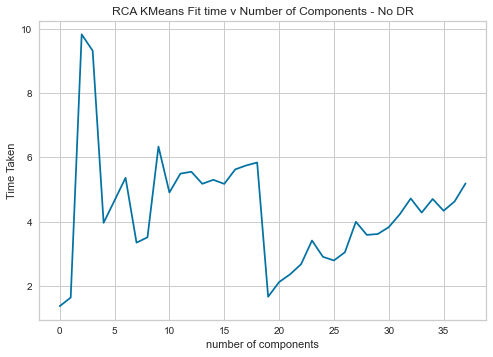

In [4]:

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encode, random_state=2, test_size=.4, stratify=y_encode)
# print(X_scaled.shape())#
# dtc.fit(X_train, y_train)
#
# y_probas = dtc.predict_proba(X_test)
# y_temp = log_loss(y_test, y_probas)
# print("log loss: ", y_temp)
#

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
times = []
lowest_bic = np.infty
bic = []
n_components_range = range(1, 20)
cv_types = ['spherical', 'diag']
best_index = 0
best_cv_type = ''
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type,
                                      warm_start=True,
                                      max_iter=100)
        t1 = time.time()
        gmm.fit(X_scaled.toarray())
        t2 = time.time()
        times.append(-(t1-t2))
        bic.append(gmm.bic(X_scaled.toarray()))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm_bic = gmm
            best_index = n_components
            best_cv_type = cv_type
bic = np.array(bic)
clf = best_gmm_bic
print("done processing models")
plt.plot(times)
plt.xlabel('number of components')
plt.ylabel('Time Taken')
plt.title("RCA KMeans Fit time v Number of Components - No DR")
plt.show()


Covariance Shape:  (19, 29421)


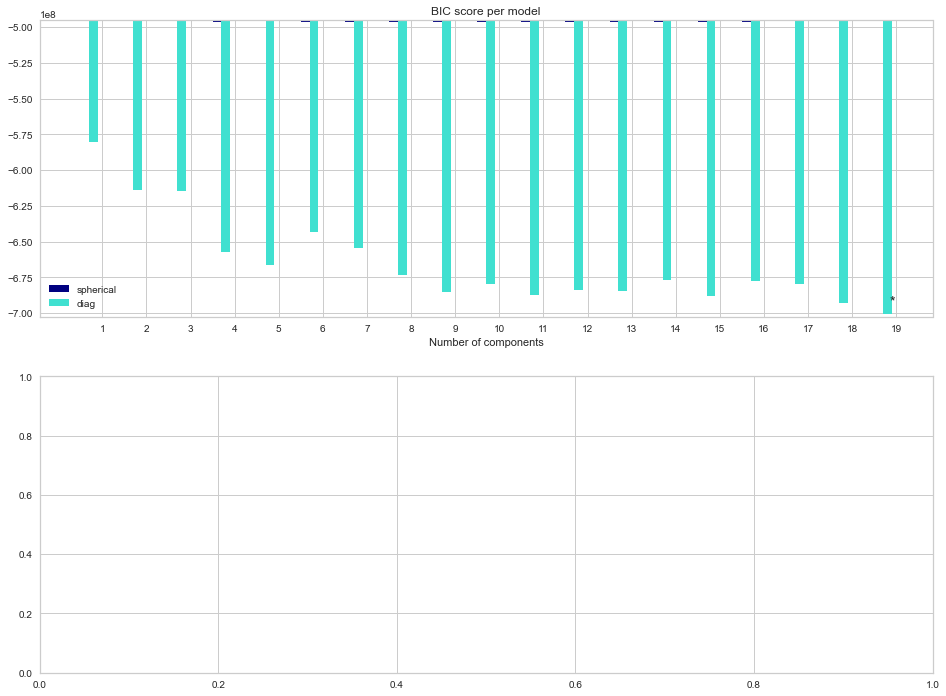

In [3]:

color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []

# Plot the BIC scores
plt.figure(figsize=(16, 12))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X_scaled)
print("Covariance Shape: ", clf.covariances_.shape)
# for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
#                                            color_iter)):
#     v, w = linalg.eigh(cov)
#     if not np.any(Y_ == i):
#         continue
#     plt.scatter(X_scaled[Y_ == i, 0], X_scaled[Y_ == i, 1], .8, color=color)
#
#     # Plot an ellipse to show the Gaussian component
#     angle = np.arctan2(w[0][1], w[0][0])
#     angle = 180. * angle / np.pi  # convert to degrees
#     v = 2. * np.sqrt(2.) * np.sqrt(v)
#     ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
#     ell.set_clip_box(splot.bbox)
#     ell.set_alpha(.5)
#     splot.add_artist(ell)
#
# # plt.xticks(())
# # plt.yticks(())
# splot.set_xlim([-4, 4])
# splot.set_ylim([-4, 4])
# title = 'Selected GMM: ', best_cv_type, ', components:  ',  best_index
# plt.title(title)
# plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()


In [4]:
lowest_aic = np.infty
aic = []
n_components_range = range(1, 20)
cv_types = ['spherical', 'diag']
best_index = 0
best_cv_type = ''
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type,
                                      warm_start=True,
                                      max_iter=100)
        gmm.fit(X_scaled)
        aic.append(gmm.aic(X_scaled))
        if aic[-1] < lowest_aic:
            lowest_aic = aic[-1]
            best_gmm = gmm
            best_index = n_components
            best_cv_type = cv_type
print("done processing aic score")


done processing aic score


ValueError: expected square "a" matrix

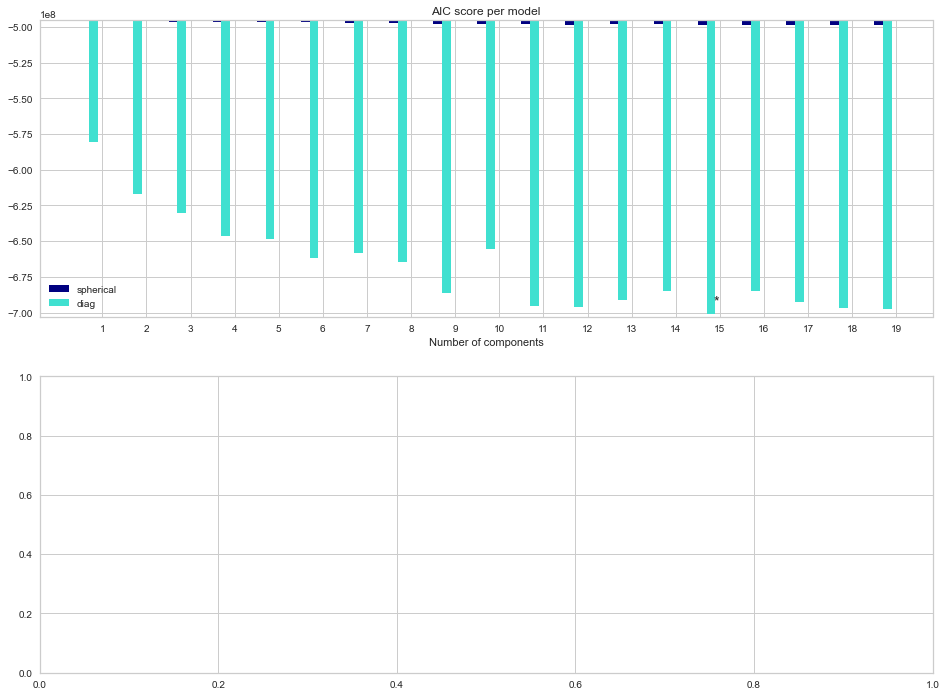

In [5]:
aic = np.array(aic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(16, 12))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, aic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([aic.min() * 1.01 - .01 * aic.max(), aic.max()])
plt.title('AIC score per model')
xpos = np.mod(aic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(aic.argmin() / len(n_components_range))
plt.text(xpos, aic.min() * 0.97 + .03 * aic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X_scaled)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X_scaled[Y_ == i, 0], X_scaled[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

# plt.xticks(range(-.5, .5))
# plt.yticks(range(-1, 1))
splot.set_xlim([-4, 4])
splot.set_ylim([-4, 4])
title = 'Selected GMM: ', best_cv_type, ', components:  ',  best_index
plt.title(title)
# plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()
print("done plotting aic scores")

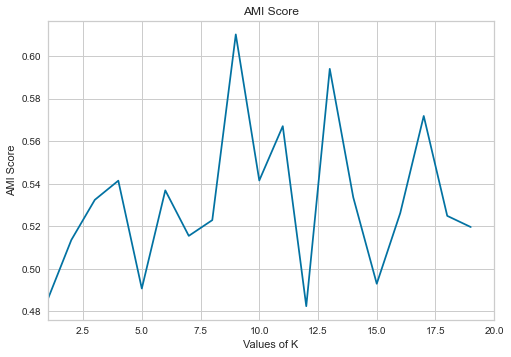

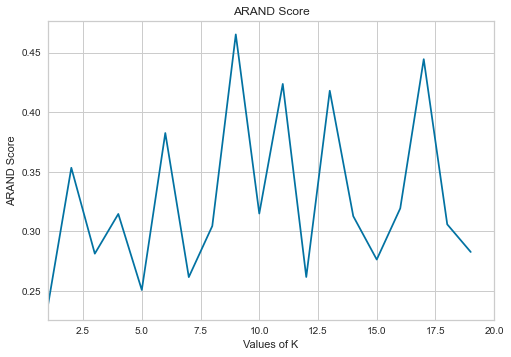

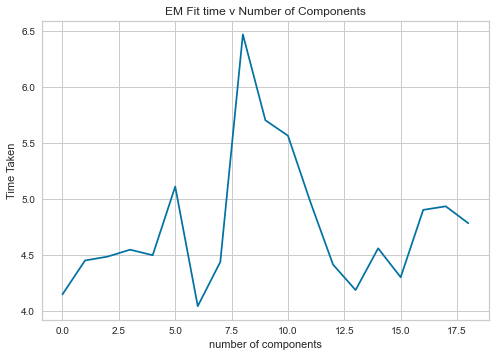

In [9]:
times = []
amis = []
arands = []
range_n_clusters = range(1, 20)
for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type,
                                      warm_start=True,
                                      max_iter=100)
    t1 = time.time()
    cluster_labels = clusterer.fit_predict(X_scaled)
    t2 = time.time()
    times.append(-(t1-t2))
    # pred = clusterer.predict(X_scaled)

    ami = adjusted_mutual_info_score(y_encode, cluster_labels)
    arand = adjusted_rand_score(y_encode, cluster_labels)
    amis.append(ami)
    arands.append(arand)

amis = np.array(amis)
arands = np.array(arands)
plt.plot(range(1,20), amis, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('AMI Score')
plt.xlim(1, 20)
plt.title('AMI Score')
plt.show()

plt.plot(range(1,20), arands, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('ARAND Score')
plt.xlim(1, 20)
plt.title('ARAND Score')
plt.show()

plt.plot(times)
plt.xlabel('number of components')
plt.ylabel('Time Taken')
plt.title("EM Fit time v Number of Components")
plt.show()

    # print("K:", n_clusters, "ami: ", ami)
    # homogeneityscore = homogeneity_score(y_encode, cluster_labels.labels_)
    # completenessscore = completeness_score(y_encode, cluster_labels.labels_)
    # vmeasurescore = v_measure_score(y_encode, cluster_labels.labels_)
    # adjmutinfo = adjusted_mutual_info_score(y,  cluster_labels.labels_)

    # print("K:", n_clusters, " homogeneity:", homogeneityscore,
    #       " completeness:", completenessscore,
    #       " vscore:", vmeasurescore,
    #       "adjmut:", adjmutinfo)

done processing models


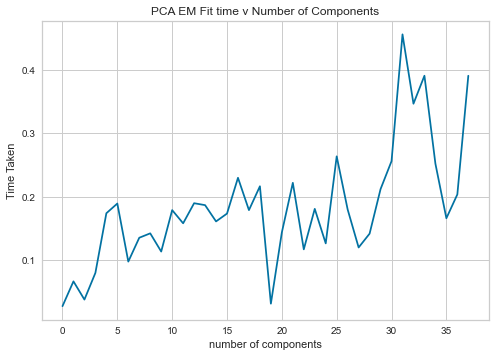

ValueError: expected square "a" matrix

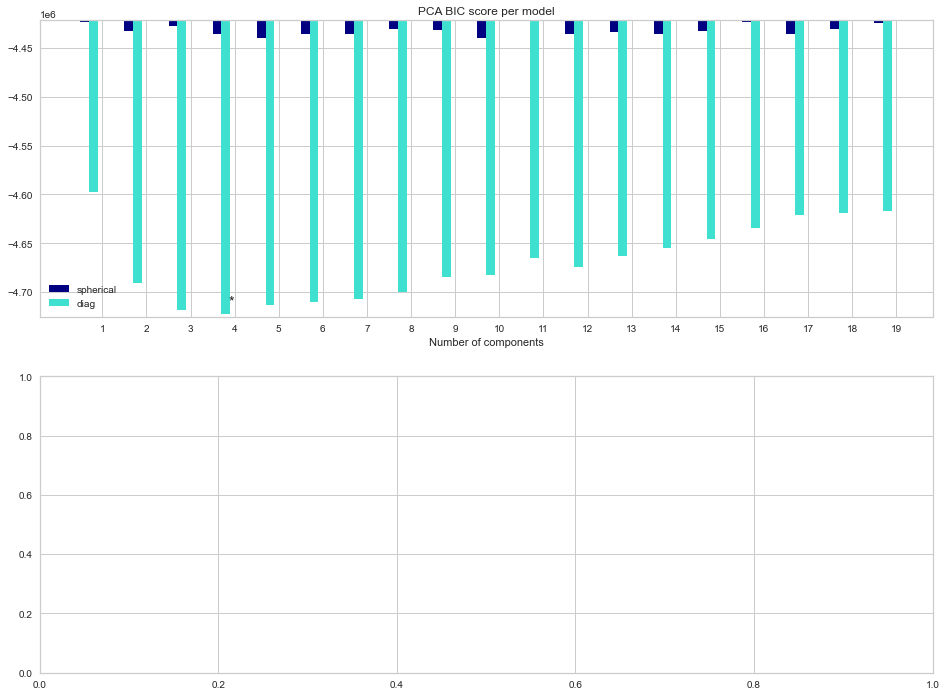

In [16]:
times = []
pca = PCA(n_components=800).fit(X_train.toarray())
pca_train = pca.transform(X_train.toarray())
lowest_bic = np.infty
bic = []
n_components_range = range(1, 20)
cv_types = ['spherical', 'diag']
best_index = 0
best_cv_type = ''
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        t1 = time.time()
        gmm.fit(pca_train)
        t2 = time.time()
        times.append(-(t1-t2))
        bic.append(gmm.bic(pca_train))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm_bic = gmm
            best_index = n_components
            best_cv_type = cv_type
print("done processing models")

plt.plot(times)
plt.xlabel('number of components')
plt.ylabel('Time Taken')
plt.title("PCA EM Fit time v Number of Components")
plt.show()

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm_bic
bars = []

# Plot the BIC scores
plt.figure(figsize=(16, 12))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('PCA BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(pca_train)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(pca_train[Y_ == i, 0], pca_train[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

# plt.xticks(())
# plt.yticks(())
splot.set_xlim([-4, 4])
splot.set_ylim([-4, 4])
title = 'Selected GMM: ', best_cv_type, ', components:  ',  best_index
plt.title(title)
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

done processing models


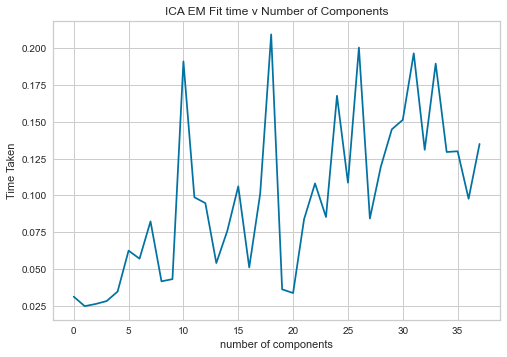

ValueError: expected square "a" matrix

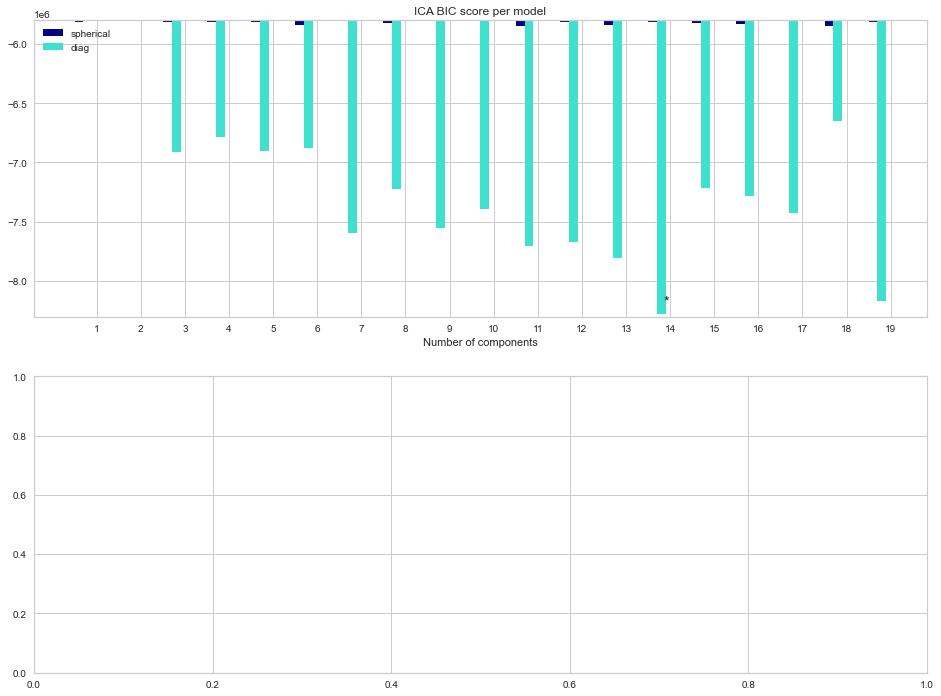

In [17]:
times = []
pca = FastICA(max_iter=500, algorithm='parallel', n_components=1000).fit(X_train.toarray())
pca_train = pca.transform(X_train.toarray())
lowest_bic = np.infty
bic = []
n_components_range = range(1, 20)
cv_types = ['spherical', 'diag']
best_index = 0
best_cv_type = ''
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        t1 = time.time()
        gmm.fit(pca_train)
        t2 = time.time()
        times.append(-(t1-t2))
        bic.append(gmm.bic(pca_train))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm_bic = gmm
            best_index = n_components
            best_cv_type = cv_type
print("done processing models")

plt.plot(times)
plt.xlabel('number of components')
plt.ylabel('Time Taken')
plt.title("ICA EM Fit time v Number of Components")
plt.show()

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm_bic
bars = []

# Plot the BIC scores
plt.figure(figsize=(16, 12))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('ICA BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(pca_train)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(pca_train[Y_ == i, 0], pca_train[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

# plt.xticks(())
# plt.yticks(())
splot.set_xlim([-4, 4])
splot.set_ylim([-4, 4])
title = 'Selected GMM: ', best_cv_type, ', components:  ',  best_index
plt.title(title)
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

done processing models


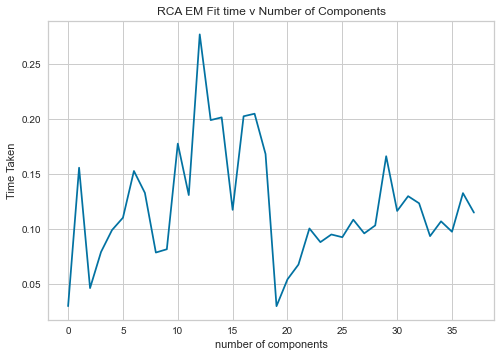

ValueError: expected square "a" matrix

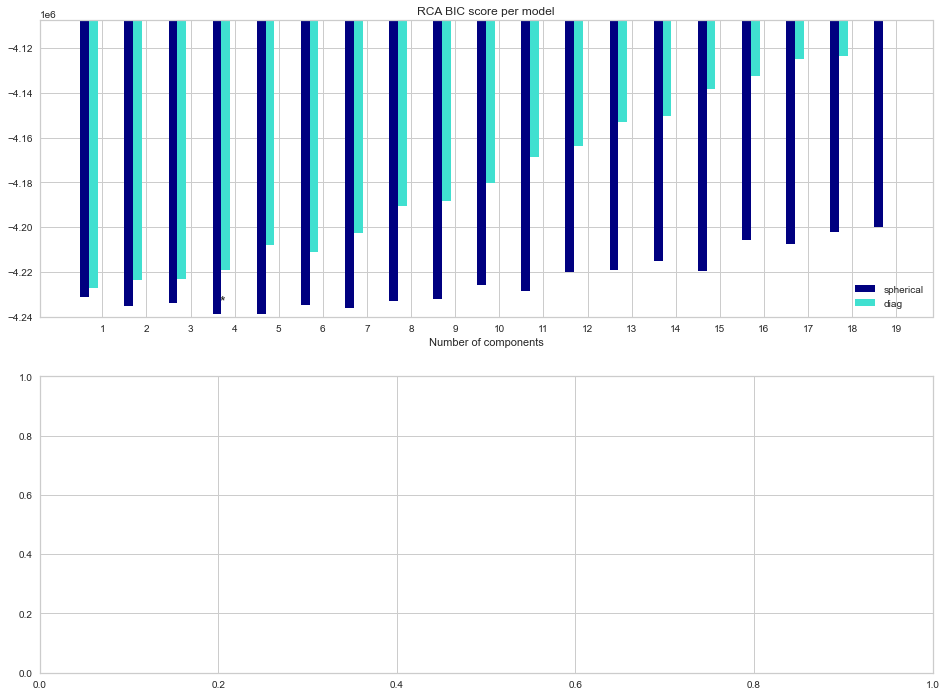

In [18]:
times = []
pca = GaussianRandomProjection(n_components=800).fit(X_train.toarray())
pca_train = pca.transform(X_train.toarray())
lowest_bic = np.infty
bic = []
n_components_range = range(1, 20)
cv_types = ['spherical', 'diag']
best_index = 0
best_cv_type = ''
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        t1 = time.time()
        gmm.fit(pca_train)
        t2 = time.time()
        times.append(-(t1-t2))
        bic.append(gmm.bic(pca_train))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm_bic = gmm
            best_index = n_components
            best_cv_type = cv_type
print("done processing models")

plt.plot(times)
plt.xlabel('number of components')
plt.ylabel('Time Taken')
plt.title("RCA EM Fit time v Number of Components")
plt.show()

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm_bic
bars = []

# Plot the BIC scores
plt.figure(figsize=(16, 12))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('RCA BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(pca_train)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(pca_train[Y_ == i, 0], pca_train[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

# plt.xticks(())
# plt.yticks(())
splot.set_xlim([-4, 4])
splot.set_ylim([-4, 4])
title = 'Selected GMM: ', best_cv_type, ', components:  ',  best_index
plt.title(title)
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

done processing models


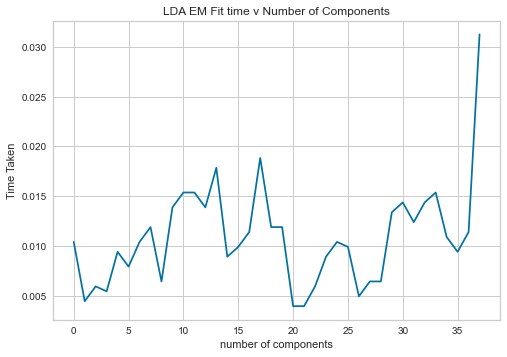

ValueError: expected square "a" matrix

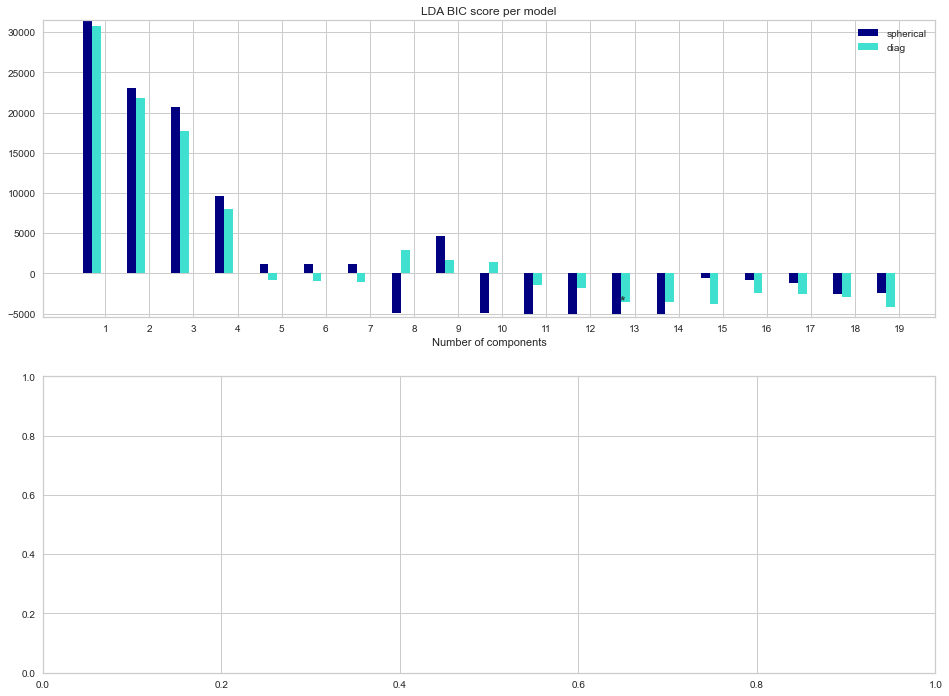

In [19]:
times = []
pca = LinearDiscriminantAnalysis(n_components=3).fit(X_train.toarray(), y_train)
pca_train = pca.transform(X_train.toarray())
lowest_bic = np.infty
bic = []
n_components_range = range(1, 20)
cv_types = ['spherical', 'diag']
best_index = 0
best_cv_type = ''
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        t1 = time.time()
        gmm.fit(pca_train)
        t2 = time.time()
        times.append(-(t1-t2))
        bic.append(gmm.bic(pca_train))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm_bic = gmm
            best_index = n_components
            best_cv_type = cv_type
print("done processing models")

plt.plot(times)
plt.xlabel('number of components')
plt.ylabel('Time Taken')
plt.title("LDA EM Fit time v Number of Components")
plt.show()

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm_bic
bars = []

# Plot the BIC scores
plt.figure(figsize=(16, 12))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('LDA BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(pca_train)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(pca_train[Y_ == i, 0], pca_train[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

# plt.xticks(())
# plt.yticks(())
splot.set_xlim([-4, 4])
splot.set_ylim([-4, 4])
title = 'Selected GMM: ', best_cv_type, ', components:  ',  best_index
plt.title(title)
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()